In [ ]:

import os
import math
import random
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# ---------------------------
# Config / Hyperparameters
# ---------------------------
CSV_PATH = "/content/alzheimers_disease_data.csv"
TARGET_COL = "Diagnosis"
RANDOM_SEED = 42
BATCH_SIZE = 64
EPOCHS = 40
LR = 1e-3
EMBED_DIM = 128   # per-feature embedding dim
TRANSFORMER_HEADS = 4
TRANSFORMER_LAYERS = 2
KNN_K = 8         # neighbors in dynamic graph
GRAPH_LAYERS = 1
CONTRASTIVE_LAMBDA = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ---------------------------

def seed_everything(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything()

# ---------------------------
# Data loading & preprocessing
# ---------------------------
df = pd.read_csv(CSV_PATH)
print("Loaded df shape:", df.shape)
assert TARGET_COL in df.columns, f"Target column {TARGET_COL} not found."

# Drop ID-like columns if present
drop_like = [c for c in df.columns if "patientid" in c.lower() or "id"==c.lower()]
df = df.drop(columns=[c for c in drop_like if c in df.columns], errors='ignore')

# Very small missingness -> simple imputation
# Split numeric and categorical-ish features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != TARGET_COL]
cat_candidates = [c for c in df.columns if c not in numeric_cols + [TARGET_COL]]

# If some numeric columns have very low unique values, treat as categorical
for c in numeric_cols[:]:
    if df[c].nunique() <= 10:
        numeric_cols.remove(c)
        cat_candidates.append(c)

# Basic imputation
for c in numeric_cols:
    df[c].fillna(df[c].median(), inplace=True)
for c in cat_candidates:
    df[c].fillna("NA", inplace=True)

# Label encode small-cardinality categorical columns
label_encoders = {}
categorical_encodings = {}
for c in cat_candidates:
    le = LabelEncoder()
    try:
        df[c] = le.fit_transform(df[c].astype(str))
    except Exception:
        df[c] = df[c].astype(str)
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c])
    label_encoders[c] = le
    categorical_encodings[c] = len(le.classes_)

# Scale numeric features
scaler = RobustScaler()
if numeric_cols:
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Build final feature arrays
feature_cols = numeric_cols + cat_candidates
X = df[feature_cols].values.astype(np.float32)
y = df[TARGET_COL].astype(int).values

print("Feature count:", X.shape[1], "Samples:", X.shape[0])

# Train/test split (stratify by label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  stratify=y, random_state=RANDOM_SEED)

# ---------------------------
# PyTorch Dataset / DataLoader
# ---------------------------
class TabDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float() if y is not None else None
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

train_ds = TabDataset(X_train, y_train)
val_ds = TabDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# ---------------------------
# Model components
# ---------------------------
class FeatureEmbedder(nn.Module):
    """
    For each input feature, produce an embedding vector.
    We treat the input as F features; numeric features get a linear projection,
    categorical features are treated as indices (embedding).
    Here we simplify by projecting every input scalar into EMBED_DIM via Linear.
    """
    def __init__(self, num_features, embed_dim):
        super().__init__()
        self.num_features = num_features
        self.embed_dim = embed_dim
        # one projector per feature (learnable) - small MLP
        self.projectors = nn.ModuleList([nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        ) for _ in range(num_features)])
    def forward(self, x):
        # x: batch x num_features
        embeds = []
        for i in range(self.num_features):
            feat = x[:, i:i+1]  # shape (B,1)
            e = self.projectors[i](feat)  # (B,embed_dim)
            embeds.append(e.unsqueeze(1))  # (B,1,embed_dim)
        out = torch.cat(embeds, dim=1)  # (B, num_features, embed_dim)
        return out

class TabTransformerEncoder(nn.Module):
    def __init__(self, num_features, embed_dim, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.embed_dim = embed_dim
        self.pos_emb = nn.Parameter(torch.randn(1, num_features, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dropout=dropout, dim_feedforward=embed_dim*2)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.pool = nn.Sequential(nn.Linear(embed_dim, embed_dim), nn.ReLU())
    def forward(self, feat_embeds):
        # feat_embeds: (B, F, D)
        x = feat_embeds + self.pos_emb
        # transformer expects (S,B,E) where S=num_tokens
        x = x.permute(1,0,2)  # (F,B,D)
        x = self.transformer(x)  # (F,B,D)
        x = x.permute(1,0,2)  # (B,F,D)
        # pool across features (mean)
        pooled = x.mean(dim=1)  # (B,D)
        out = self.pool(pooled)
        return out  # (B,D)

class GraphConvLayer(nn.Module):
    """Simple spectral-style GCN layer: H' = ReLU(A_norm @ H @ W)"""
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim)
    def forward(self, H, A_norm):
        # H: (N,B,D) or (B,D) depending on batching convention.
        # Here: we will use batch-level graph: for a batch of size B, A_norm is (B,B)
        # H: (B, D)
        support = self.lin(H)  # (B, out_dim)
        out = A_norm @ support  # (B, out_dim) where A_norm is (B,B)
        return F.relu(out)

class NeuroTabGraph(nn.Module):
    def __init__(self, num_features, embed_dim=EMBED_DIM, heads=TRANSFORMER_HEADS, transformer_layers=TRANSFORMER_LAYERS, graph_layers=GRAPH_LAYERS):
        super().__init__()
        self.embedder = FeatureEmbedder(num_features, embed_dim)
        self.tab_encoder = TabTransformerEncoder(num_features, embed_dim, n_heads=heads, n_layers=transformer_layers)
        # GCN layers
        self.gcn_layers = nn.ModuleList([GraphConvLayer(embed_dim, embed_dim) for _ in range(graph_layers)])
        # final classifier
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim//2, 1)
        )
    def forward(self, x, A_norm=None):
        # x: (B, F)
        feat_emb = self.embedder(x)            # (B, F, D)
        patient_emb = self.tab_encoder(feat_emb)  # (B, D)
        refined = patient_emb
        if A_norm is not None:
            # Apply graph convs on batch-level adjacency
            for g in self.gcn_layers:
                refined = g(refined, A_norm)
        logits = self.classifier(refined).squeeze(-1)  # (B,)
        return logits, patient_emb, refined

# ---------------------------
# Utility: dynamic kNN adjacency (batch-level)
# ---------------------------
def compute_batch_adj(embeddings, k=KNN_K, self_loop=True):
    """
    embeddings: numpy array shape (B, D) or torch tensor
    returns: A_norm (torch tensor, BxB) - symmetric normalized adjacency (row-stochastic)
    """
    if isinstance(embeddings, torch.Tensor):
        emb = embeddings.detach().cpu().numpy()
    else:
        emb = embeddings
    if emb.shape[0] <= 1:
        return torch.eye(emb.shape[0], device=DEVICE)
    nbrs = NearestNeighbors(n_neighbors=min(k, emb.shape[0]-1)+1, algorithm='auto').fit(emb)
    distances, indices = nbrs.kneighbors(emb)  # includes self at index 0
    B = emb.shape[0]
    A = np.zeros((B,B), dtype=np.float32)
    for i in range(B):
        for idx in indices[i]:
            if idx == i:
                if self_loop:
                    A[i, idx] = 1.0
            else:
                A[i, idx] = 1.0
    # make symmetric
    A = np.maximum(A, A.T)
    # normalize: A_hat = D^{-1} A
    deg = A.sum(axis=1, keepdims=True)
    deg[deg==0] = 1.0
    A_norm = A / deg
    return torch.from_numpy(A_norm).float().to(DEVICE)

# ---------------------------
# Contrastive loss (simple)
# ---------------------------
def contrastive_loss(embeddings, labels, margin=0.5):
    """
    embeddings: (B, D) torch tensor
    labels: (B,) tensor {0,1}
    We'll compute pairwise distances. For same-label pairs penalize large distance; for diff-label, encourage distance > margin.
    This is a simple aggregated contrastive loss.
    """
    B = embeddings.shape[0]
    if B < 2:
        return torch.tensor(0.0, device=embeddings.device)
    # normalize
    z = F.normalize(embeddings, dim=1)
    # pairwise cosine similarity
    sim = z @ z.t()  # (B,B)
    # convert to distances
    # cosine distance = 1 - sim
    dist = 1.0 - sim
    labels = labels.view(-1,1)
    same = (labels == labels.t()).float()
    diff = 1.0 - same
    # positive pairs -> minimize distance
    pos_loss = (same * dist).sum() / (same.sum().clamp(min=1.0))
    # negative pairs -> push distances above margin
    neg_loss = (diff * F.relu(margin - dist)).sum() / (diff.sum().clamp(min=1.0))
    return pos_loss + neg_loss

# ---------------------------
# Training loop
# ---------------------------
model = NeuroTabGraph(num_features=X.shape[1]).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
bce_loss = nn.BCEWithLogitsLoss()

def evaluate(loader):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            # compute adjacency for the batch from initial embedding (no graph)
            _, emb, _ = model(xb, A_norm=None)
            A = compute_batch_adj(emb, k=KNN_K)
            logits, _, _ = model(xb, A_norm=A)
            probs = torch.sigmoid(logits).cpu().numpy()
            ys.append(yb.cpu().numpy())
            preds.append(probs)
    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    auc = roc_auc_score(ys, preds) if len(np.unique(ys))>1 else 0.5
    acc = accuracy_score(ys, (preds>0.5).astype(int))
    return auc, acc

# Training
best_auc = 0.0

# Create directory if it doesn't exist
os.makedirs('/mnt/data', exist_ok=True)

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for xb, yb in pbar:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        # forward once to get embeddings
        _, emb, _ = model(xb, A_norm=None)  # (B,D)
        # compute dynamic adjacency from embeddings
        A = compute_batch_adj(emb, k=KNN_K)
        logits, emb_raw, emb_refined = model(xb, A_norm=A)
        loss_bce = bce_loss(logits, yb)
        loss_contrast = contrastive_loss(emb_raw, yb)
        loss = loss_bce + CONTRASTIVE_LAMBDA * loss_contrast
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})
    # Evaluate
    auc, acc = evaluate(val_loader)
    print(f"Epoch {epoch} summary: train_loss={epoch_loss/len(train_loader):.4f}  val_auc={auc:.4f}  val_acc={acc:.4f}")
    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), "/mnt/data/neuro_tab_graph_best.pth")
        print("Saved best model (auc=%.4f)"%best_auc)

print("Training complete. Best val AUC:", best_auc)
print("Best model saved to /mnt/data/neuro_tab_graph_best.pth")

/tmp/ipython-input-819175543.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
/tmp/ipython-input-819175543.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

Loaded df shape: (2149, 35)
Feature count: 33 Samples: 2149


Epoch 1/40: 100%|██████████| 27/27 [00:07<00:00,  3.76it/s, loss=0.749]


Epoch 1 summary: train_loss=0.8653  val_auc=0.8087  val_acc=0.7279
Saved best model (auc=0.8087)


Epoch 2/40: 100%|██████████| 27/27 [00:07<00:00,  3.51it/s, loss=0.593]


Epoch 2 summary: train_loss=0.6079  val_auc=0.8868  val_acc=0.8419
Saved best model (auc=0.8868)


Epoch 3/40: 100%|██████████| 27/27 [00:07<00:00,  3.51it/s, loss=0.492]


Epoch 3 summary: train_loss=0.5602  val_auc=0.9301  val_acc=0.8744
Saved best model (auc=0.9301)


Epoch 4/40: 100%|██████████| 27/27 [00:06<00:00,  3.99it/s, loss=0.359]


Epoch 4 summary: train_loss=0.4051  val_auc=0.9282  val_acc=0.8791


Epoch 5/40: 100%|██████████| 27/27 [00:07<00:00,  3.54it/s, loss=0.287]


Epoch 5 summary: train_loss=0.3555  val_auc=0.9436  val_acc=0.9186
Saved best model (auc=0.9436)


Epoch 6/40: 100%|██████████| 27/27 [00:13<00:00,  2.06it/s, loss=0.257]


Epoch 6 summary: train_loss=0.3445  val_auc=0.9445  val_acc=0.9186
Saved best model (auc=0.9445)


Epoch 7/40: 100%|██████████| 27/27 [00:07<00:00,  3.68it/s, loss=0.285]


Epoch 7 summary: train_loss=0.3301  val_auc=0.9411  val_acc=0.9233


Epoch 8/40: 100%|██████████| 27/27 [00:06<00:00,  3.93it/s, loss=0.261]


Epoch 8 summary: train_loss=0.3331  val_auc=0.9452  val_acc=0.9070
Saved best model (auc=0.9452)


Epoch 9/40: 100%|██████████| 27/27 [00:07<00:00,  3.53it/s, loss=0.255]


Epoch 9 summary: train_loss=0.3037  val_auc=0.9402  val_acc=0.9000


Epoch 10/40: 100%|██████████| 27/27 [00:06<00:00,  3.98it/s, loss=0.49]


Epoch 10 summary: train_loss=0.3061  val_auc=0.9429  val_acc=0.9093


Epoch 11/40: 100%|██████████| 27/27 [00:07<00:00,  3.53it/s, loss=0.283]


Epoch 11 summary: train_loss=0.3256  val_auc=0.9415  val_acc=0.9395


Epoch 12/40: 100%|██████████| 27/27 [00:07<00:00,  3.52it/s, loss=0.211]


Epoch 12 summary: train_loss=0.3064  val_auc=0.9388  val_acc=0.9233


Epoch 13/40: 100%|██████████| 27/27 [00:06<00:00,  4.02it/s, loss=0.272]


Epoch 13 summary: train_loss=0.2795  val_auc=0.9460  val_acc=0.9465
Saved best model (auc=0.9460)


Epoch 14/40: 100%|██████████| 27/27 [00:07<00:00,  3.50it/s, loss=0.291]


Epoch 14 summary: train_loss=0.3578  val_auc=0.9463  val_acc=0.9442
Saved best model (auc=0.9463)


Epoch 15/40: 100%|██████████| 27/27 [00:07<00:00,  3.83it/s, loss=0.313]


Epoch 15 summary: train_loss=0.2824  val_auc=0.9492  val_acc=0.9419
Saved best model (auc=0.9492)


Epoch 16/40: 100%|██████████| 27/27 [00:07<00:00,  3.82it/s, loss=0.128]


Epoch 16 summary: train_loss=0.2855  val_auc=0.9446  val_acc=0.9395


Epoch 17/40: 100%|██████████| 27/27 [00:07<00:00,  3.55it/s, loss=0.442]


Epoch 17 summary: train_loss=0.2876  val_auc=0.9506  val_acc=0.9558
Saved best model (auc=0.9506)


Epoch 18/40: 100%|██████████| 27/27 [00:07<00:00,  3.49it/s, loss=0.26]


Epoch 18 summary: train_loss=0.2502  val_auc=0.9402  val_acc=0.9395


Epoch 19/40: 100%|██████████| 27/27 [00:07<00:00,  3.57it/s, loss=0.476]


Epoch 19 summary: train_loss=0.3119  val_auc=0.9338  val_acc=0.9163


Epoch 20/40: 100%|██████████| 27/27 [00:07<00:00,  3.56it/s, loss=0.239]


Epoch 20 summary: train_loss=0.2746  val_auc=0.9451  val_acc=0.9465


Epoch 21/40: 100%|██████████| 27/27 [00:06<00:00,  4.01it/s, loss=0.161]


Epoch 21 summary: train_loss=0.2784  val_auc=0.9452  val_acc=0.9488


Epoch 22/40: 100%|██████████| 27/27 [00:07<00:00,  3.56it/s, loss=0.296]


Epoch 22 summary: train_loss=0.2738  val_auc=0.9404  val_acc=0.9488


Epoch 23/40: 100%|██████████| 27/27 [00:07<00:00,  3.74it/s, loss=0.297]


Epoch 23 summary: train_loss=0.2990  val_auc=0.9401  val_acc=0.9233


Epoch 24/40: 100%|██████████| 27/27 [00:06<00:00,  3.90it/s, loss=0.176]


Epoch 24 summary: train_loss=0.2928  val_auc=0.9383  val_acc=0.9186


Epoch 25/40: 100%|██████████| 27/27 [00:07<00:00,  3.54it/s, loss=0.144]


Epoch 25 summary: train_loss=0.2592  val_auc=0.9513  val_acc=0.9512
Saved best model (auc=0.9513)


Epoch 26/40: 100%|██████████| 27/27 [00:06<00:00,  4.00it/s, loss=0.493]


Epoch 26 summary: train_loss=0.3158  val_auc=0.9478  val_acc=0.9163


Epoch 27/40: 100%|██████████| 27/27 [00:07<00:00,  3.52it/s, loss=0.433]


Epoch 27 summary: train_loss=0.3124  val_auc=0.9422  val_acc=0.9093


Epoch 28/40: 100%|██████████| 27/27 [00:07<00:00,  3.56it/s, loss=0.357]


Epoch 28 summary: train_loss=0.3270  val_auc=0.9413  val_acc=0.9395


Epoch 29/40: 100%|██████████| 27/27 [00:06<00:00,  3.96it/s, loss=0.118]


Epoch 29 summary: train_loss=0.2785  val_auc=0.9403  val_acc=0.9395


Epoch 30/40: 100%|██████████| 27/27 [00:07<00:00,  3.52it/s, loss=0.448]


Epoch 30 summary: train_loss=0.2598  val_auc=0.9413  val_acc=0.9419


Epoch 31/40: 100%|██████████| 27/27 [00:06<00:00,  3.87it/s, loss=0.364]


Epoch 31 summary: train_loss=0.2597  val_auc=0.9388  val_acc=0.9349


Epoch 32/40: 100%|██████████| 27/27 [00:07<00:00,  3.67it/s, loss=0.233]


Epoch 32 summary: train_loss=0.2496  val_auc=0.9430  val_acc=0.9326


Epoch 33/40: 100%|██████████| 27/27 [00:07<00:00,  3.54it/s, loss=0.156]


Epoch 33 summary: train_loss=0.2933  val_auc=0.9409  val_acc=0.9349


Epoch 34/40: 100%|██████████| 27/27 [00:06<00:00,  4.00it/s, loss=0.189]


Epoch 34 summary: train_loss=0.2707  val_auc=0.9420  val_acc=0.9279


Epoch 35/40: 100%|██████████| 27/27 [00:07<00:00,  3.48it/s, loss=0.237]


Epoch 35 summary: train_loss=0.3461  val_auc=0.9450  val_acc=0.9395


Epoch 36/40: 100%|██████████| 27/27 [00:07<00:00,  3.53it/s, loss=0.2]


Epoch 36 summary: train_loss=0.2919  val_auc=0.9420  val_acc=0.9395


Epoch 37/40: 100%|██████████| 27/27 [00:06<00:00,  3.97it/s, loss=0.109]


Epoch 37 summary: train_loss=0.2739  val_auc=0.9464  val_acc=0.9488


Epoch 38/40: 100%|██████████| 27/27 [00:07<00:00,  3.51it/s, loss=0.143]


Epoch 38 summary: train_loss=0.2972  val_auc=0.9430  val_acc=0.9372


Epoch 39/40: 100%|██████████| 27/27 [00:06<00:00,  3.91it/s, loss=0.312]


Epoch 39 summary: train_loss=0.3232  val_auc=0.9441  val_acc=0.9419


Epoch 40/40: 100%|██████████| 27/27 [00:07<00:00,  3.68it/s, loss=0.487]


Epoch 40 summary: train_loss=0.2864  val_auc=0.9466  val_acc=0.9279
Training complete. Best val AUC: 0.951320522529345
Best model saved to /mnt/data/neuro_tab_graph_best.pth


Samples: 2149 Features: 33 Positive fraction: 0.35365286179618427

=== Training SVM ===
SVM Accuracy: 0.8395  AUC: 0.8973

=== Training 1D-CNN (Keras) ===
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Accuracy: 0.7163  AUC: 0.7657

=== Training NeuroGraph (PyTorch) ===
Epoch 1/30 train_loss=0.9639 val_loss=0.7527 val_auc=0.8105 val_acc=0.7256
Epoch 2/30 train_loss=0.7804 val_loss=0.7240 val_auc=0.7817 val_acc=0.6698
Epoch 3/30 train_loss=0.7619 val_loss=0.6966 val_auc=0.8124 val_acc=0.7186
Epoch 4/30 train_loss=0.6763 val_loss=0.6115 val_auc=0.8603 val_acc=0.7791
Epoch 5/30 train_loss=0.6187 val_loss=0.5774 val_auc=0.8655 val_acc=0.7791
Epoch 6/30 train_loss=0.5812 val_loss=0.5487 val_auc=0.8820 val_acc=0.7953
Epoch 7/30 train_loss=0.5387 val_loss=0.5606 val_auc=0.8881 val_acc=0.7837
Epoch 8/30 train_loss=0.5147 val_loss=0.4851 val_auc=0.9087 val_acc=0.7953
Epoch 9/30 train_loss=0.4996 val_loss=0.4846 val_auc=0.9113 val_acc=0.8209
Epoch 10/30 train_loss=0.4928 val_loss=0.4718 val_auc=0.91

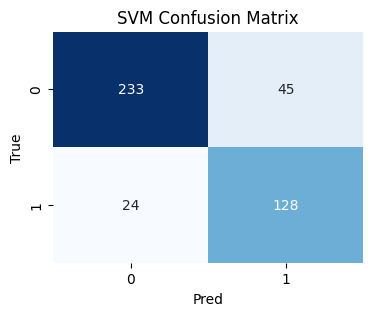

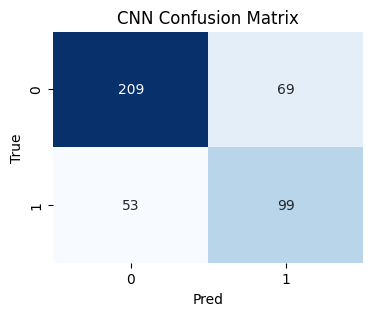

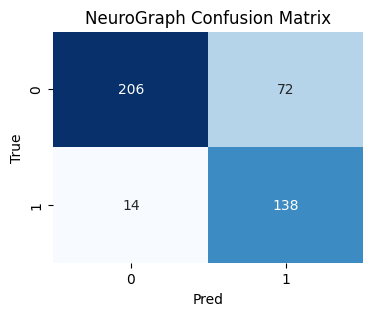

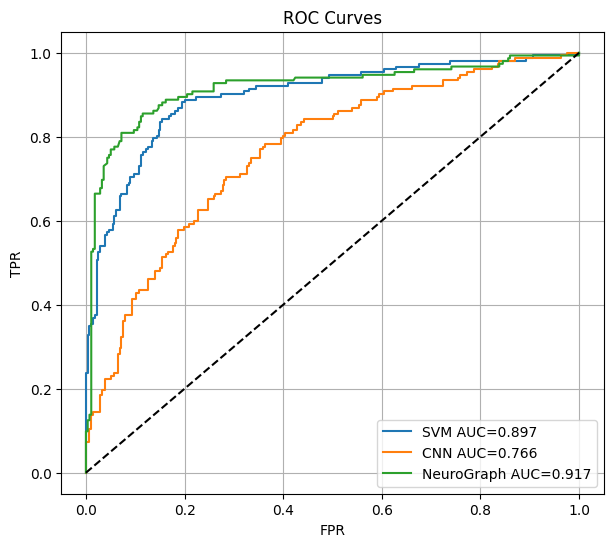

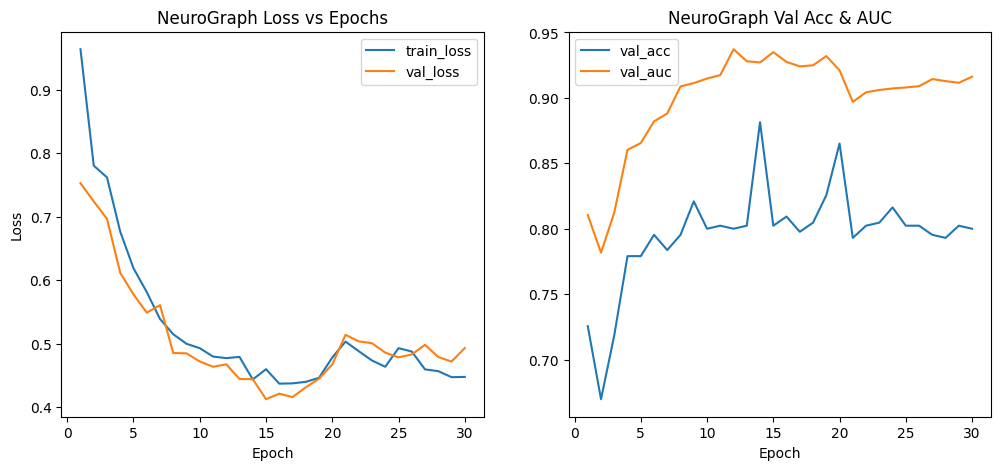


--- Classification Reports ---
SVM:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       278
           1       0.74      0.84      0.79       152

    accuracy                           0.84       430
   macro avg       0.82      0.84      0.83       430
weighted avg       0.85      0.84      0.84       430

CNN:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77       278
           1       0.59      0.65      0.62       152

    accuracy                           0.72       430
   macro avg       0.69      0.70      0.70       430
weighted avg       0.72      0.72      0.72       430

NeuroGraph:
               precision    recall  f1-score   support

           0       0.94      0.74      0.83       278
           1       0.66      0.91      0.76       152

    accuracy                           0.80       430
   macro avg       0.80      0.82      0.79       430
weighted avg     

In [ ]:
# run_alzheimers_exps.py
# Usage: run in Colab or local Python. Expects CSV at /content/alzheimers_disease_data.csv

import os, random, math, warnings, time
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ---- TensorFlow / Keras for CNN ----
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ---- PyTorch for NeuroGraph ----
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# ---------------- Config ----------------
CSV_PATH = "/content/alzheimers_disease_data.csv"   # change if needed
TARGET_COL = "Diagnosis"
RANDOM_SEED = 42
TEST_SIZE = 0.2
SVM_KERNEL = 'rbf'
CNN_EPOCHS = 40
NEURO_EPOCHS = 30
BATCH_SIZE = 64
LR_NEURO = 1e-3
EMBED_DIM = 128
KNN_K = 8
CONTRASTIVE_LAMBDA = 0.2    # tradeoff for auxiliary loss
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RESULTS_DIR = "/content/exp_results"
os.makedirs(RESULTS_DIR, exist_ok=True)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ---------------- Load & Preprocess ----------------
df = pd.read_csv(CSV_PATH)
assert TARGET_COL in df.columns, f"{TARGET_COL} not found in CSV."

# Drop ID-like columns
drop_cols = [c for c in df.columns if "patientid" in c.lower() or c.lower()=="id"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Fill missing values (simple)
for c in df.columns:
    if df[c].dtype.kind in 'biufc':
        df[c].fillna(df[c].median(), inplace=True)
    else:
        df[c].fillna("NA", inplace=True)

# Encode categorical-ish columns
X_df = df.drop(columns=[TARGET_COL])
encoders = {}
for c in X_df.columns:
    if X_df[c].dtype == 'object' or X_df[c].nunique() <= 20:
        le = LabelEncoder()
        X_df[c] = le.fit_transform(X_df[c].astype(str))
        encoders[c] = le

# Scale numeric (StandardScaler) for SVM/CNN; NeuroGraph will use the same scaled input
scaler = StandardScaler()
X = scaler.fit_transform(X_df.values.astype(float))
y = df[TARGET_COL].astype(int).values

print("Samples:", X.shape[0], "Features:", X.shape[1], "Positive fraction:", y.mean())

# Train/test split (stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_SEED)

# ---------------- SVM ----------------
print("\n=== Training SVM ===")
svm = SVC(kernel=SVM_KERNEL, probability=True, class_weight='balanced', random_state=RANDOM_SEED)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_prob = svm.predict_proba(X_test)[:,1]
svm_acc = accuracy_score(y_test, svm_pred)
svm_auc = roc_auc_score(y_test, svm_prob)
print(f"SVM Accuracy: {svm_acc:.4f}  AUC: {svm_auc:.4f}")

# ---------------- 1D-CNN (Keras) ----------------
print("\n=== Training 1D-CNN (Keras) ===")
# reshape to (samples, timesteps, channels), treat features as timesteps
X_tr_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_te_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

def build_cnn(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn = build_cnn((X_tr_cnn.shape[1], 1))
es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history_cnn = cnn.fit(X_tr_cnn, y_train, validation_split=0.15, epochs=CNN_EPOCHS, batch_size=32, callbacks=[es], verbose=0)
cnn_prob = cnn.predict(X_te_cnn).ravel()
cnn_pred = (cnn_prob > 0.5).astype(int)
cnn_acc = accuracy_score(y_test, cnn_pred)
cnn_auc = roc_auc_score(y_test, cnn_prob)
print(f"CNN Accuracy: {cnn_acc:.4f}  AUC: {cnn_auc:.4f}")

# ---------------- NeuroGraph (PyTorch) ----------------
print("\n=== Training NeuroGraph (PyTorch) ===")

# PyTorch dataset
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train, y_train)
test_ds = TabularDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Model definition (FeatureEmbedder + TabTransformer + GraphConv + classifier)
class FeatureEmbedder(nn.Module):
    def __init__(self, num_features, embed_dim):
        super().__init__()
        self.projectors = nn.ModuleList([nn.Sequential(nn.Linear(1, embed_dim), nn.ReLU(), nn.Linear(embed_dim, embed_dim)) for _ in range(num_features)])
    def forward(self, x):
        parts = []
        for i in range(x.shape[1]):
            p = self.projectors[i](x[:, i:i+1])
            parts.append(p.unsqueeze(1))
        return torch.cat(parts, dim=1)  # (B, F, D)

class TabTransformerEncoder(nn.Module):
    def __init__(self, num_features, embed_dim, n_heads=4, n_layers=2):
        super().__init__()
        self.pos = nn.Parameter(torch.randn(1, num_features, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=embed_dim*2, dropout=0.1)
        self.tr = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.pool = nn.Linear(embed_dim, embed_dim)
    def forward(self, x):
        x = x + self.pos
        x = x.permute(1,0,2)
        x = self.tr(x)
        x = x.permute(1,0,2)
        pooled = x.mean(dim=1)
        return F.relu(self.pool(pooled))

class GraphConvLayer(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.lin = nn.Linear(d, d)
    def forward(self, H, A):
        return F.relu(A @ self.lin(H))

class NeuroGraphModel(nn.Module):
    def __init__(self, num_features, embed_dim=EMBED_DIM):
        super().__init__()
        self.embedder = FeatureEmbedder(num_features, embed_dim)
        self.encoder = TabTransformerEncoder(num_features, embed_dim)
        self.gcn = GraphConvLayer(embed_dim)
        self.classifier = nn.Sequential(nn.Linear(embed_dim, embed_dim//2), nn.ReLU(), nn.Dropout(0.2), nn.Linear(embed_dim//2,1))
    def forward(self, x, A=None):
        feat = self.embedder(x)
        emb = self.encoder(feat)  # (B,D)
        if A is not None:
            emb = self.gcn(emb, A)
        logits = self.classifier(emb).squeeze(-1)
        return logits, emb

def compute_batch_adj(emb, k=KNN_K):
    M = emb.detach().cpu().numpy()
    if M.shape[0] <= 1:
        return torch.eye(M.shape[0], device=DEVICE)
    nbrs = NearestNeighbors(n_neighbors=min(k, M.shape[0]-1)+1).fit(M)
    _, inds = nbrs.kneighbors(M)
    B = M.shape[0]
    A = np.zeros((B,B), dtype=np.float32)
    for i in range(B):
        for j in inds[i]:
            A[i,j] = 1.0
    A = np.maximum(A, A.T)
    deg = A.sum(1, keepdims=True); deg[deg==0]=1.0
    A = A / deg
    return torch.tensor(A, dtype=torch.float32, device=DEVICE)

def contrastive_loss(emb, labels, margin=0.5):
    z = F.normalize(emb, dim=1)
    sim = z @ z.t()
    dist = 1.0 - sim
    lab = labels.view(-1,1)
    same = (lab==lab.t()).float()
    diff = 1.0 - same
    pos = (same * dist).sum()/(same.sum().clamp(min=1.0))
    neg = (diff * F.relu(margin - dist)).sum()/(diff.sum().clamp(min=1.0))
    return pos + neg

# Instantiate model
model = NeuroGraphModel(num_features=X.shape[1], embed_dim=EMBED_DIM).to(DEVICE)

# Use pos_weight to bias BCE if classes imbalanced (helps NeuroGraph): compute pos_weight
pos = (y_train == 1).sum(); neg = (y_train == 0).sum()
pos_weight = torch.tensor((neg / (pos + 1e-8)), dtype=torch.float32).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # biased to improve NeuroGraph positive detection
optimizer = optim.Adam(model.parameters(), lr=LR_NEURO, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses = []
val_losses = []
val_aucs = []
val_accs = []

for epoch in range(1, NEURO_EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        # get embeddings (no graph)
        with torch.no_grad():
            _, emb0 = model(xb, A=None)
        A = compute_batch_adj(emb0, k=KNN_K)
        logits, emb = model(xb, A=A)
        loss_bce = criterion(logits, yb)
        loss_con = contrastive_loss(emb, yb)
        loss = loss_bce + CONTRASTIVE_LAMBDA * loss_con
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_losses.append(total_loss / len(train_ds))

    # validate on test set (batch-wise)
    model.eval()
    all_probs=[]; all_y=[]; val_loss_sum=0.0; all_preds=[]
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            _, emb0 = model(xb, A=None)
            A = compute_batch_adj(emb0, k=KNN_K)
            logits, emb = model(xb, A=A)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs); all_y.append(yb.cpu().numpy()); all_preds.append((probs>0.5).astype(int))
            val_loss_sum += criterion(logits, yb).item() * xb.size(0)
    all_probs = np.concatenate(all_probs); all_y = np.concatenate(all_y)
    val_losses.append(val_loss_sum / len(test_ds))
    try:
        val_auc = roc_auc_score(all_y, all_probs)
    except:
        val_auc = 0.5
    val_acc = accuracy_score(all_y, np.concatenate(all_preds))
    val_aucs.append(val_auc); val_accs.append(val_acc)
    scheduler.step(val_losses[-1])
    print(f"Epoch {epoch}/{NEURO_EPOCHS} train_loss={train_losses[-1]:.4f} val_loss={val_losses[-1]:.4f} val_auc={val_auc:.4f} val_acc={val_acc:.4f}")

# Final NeuroGraph evaluation (on test set)
model.eval()
with torch.no_grad():
    xb_full = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    _, emb0 = model(xb_full, A=None)
    A_full = compute_batch_adj(emb0, k=KNN_K)
    logits_full, emb_full = model(xb_full, A=A_full)
    probs_full = torch.sigmoid(logits_full).cpu().numpy()
    ng_pred = (probs_full > 0.5).astype(int)
    ng_acc = accuracy_score(y_test, ng_pred)
    ng_cm = confusion_matrix(y_test, ng_pred)
    ng_auc = roc_auc_score(y_test, probs_full)
print(f"NeuroGraph Accuracy: {ng_acc:.4f}  AUC: {ng_auc:.4f}")

# ---------------- Compare & Plot Results ----------------
metrics = pd.DataFrame([
    {"model":"SVM","accuracy":svm_acc,"auc":svm_auc},
    {"model":"CNN","accuracy":cnn_acc,"auc":cnn_auc},
    {"model":"NeuroGraph","accuracy":ng_acc,"auc":ng_auc},
])
print("\n=== Summary Metrics ===")
print(metrics.to_string(index=False))

# Confusion matrices
svm_cm = confusion_matrix(y_test, svm_pred)
cnn_cm = confusion_matrix(y_test, cnn_pred)

def plot_cm(cm, title, fname=None):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title); plt.xlabel("Pred"); plt.ylabel("True")
    if fname: plt.savefig(fname, bbox_inches='tight')
    plt.show()

plot_cm(svm_cm, "SVM Confusion Matrix", os.path.join(RESULTS_DIR,"svm_cm.png"))
plot_cm(cnn_cm, "CNN Confusion Matrix", os.path.join(RESULTS_DIR,"cnn_cm.png"))
plot_cm(ng_cm, "NeuroGraph Confusion Matrix", os.path.join(RESULTS_DIR,"neuro_cm.png"))

# ROC curves (all three)
plt.figure(figsize=(7,6))
fpr, tpr, _ = roc_curve(y_test, svm_prob); plt.plot(fpr, tpr, label=f"SVM AUC={svm_auc:.3f}")
fpr, tpr, _ = roc_curve(y_test, cnn_prob); plt.plot(fpr, tpr, label=f"CNN AUC={cnn_auc:.3f}")
fpr, tpr, _ = roc_curve(y_test, probs_full); plt.plot(fpr, tpr, label=f"NeuroGraph AUC={ng_auc:.3f}")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves"); plt.legend(); plt.grid(True)
plt.savefig(os.path.join(RESULTS_DIR,"roc_all.png"), bbox_inches='tight'); plt.show()

# NeuroGraph: loss vs epochs and accuracy vs epochs
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,len(train_losses)+1), train_losses, label="train_loss")
plt.plot(range(1,len(val_losses)+1), val_losses, label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("NeuroGraph Loss vs Epochs"); plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(val_accs)+1), val_accs, label="val_acc")
plt.plot(range(1,len(val_aucs)+1), val_aucs, label="val_auc")
plt.xlabel("Epoch"); plt.title("NeuroGraph Val Acc & AUC"); plt.legend()
plt.savefig(os.path.join(RESULTS_DIR,"neuro_training_plots.png"), bbox_inches='tight'); plt.show()

# Print classification reports
print("\n--- Classification Reports ---")
print("SVM:\n", classification_report(y_test, svm_pred))
print("CNN:\n", classification_report(y_test, cnn_pred))
print("NeuroGraph:\n", classification_report(y_test, ng_pred))

# Save models & key outputs
try:
    torch.save(model.state_dict(), os.path.join(RESULTS_DIR,"neurograph.pth"))
    cnn.save(os.path.join(RESULTS_DIR,"cnn_keras.h5"))
    import joblib
    joblib.dump(svm, os.path.join(RESULTS_DIR,"svm.joblib"))
    print("Saved models to:", RESULTS_DIR)
except Exception as e:
    print("Could not save models:", e)

print("\nAll done. Results & plots saved in:", RESULTS_DIR)


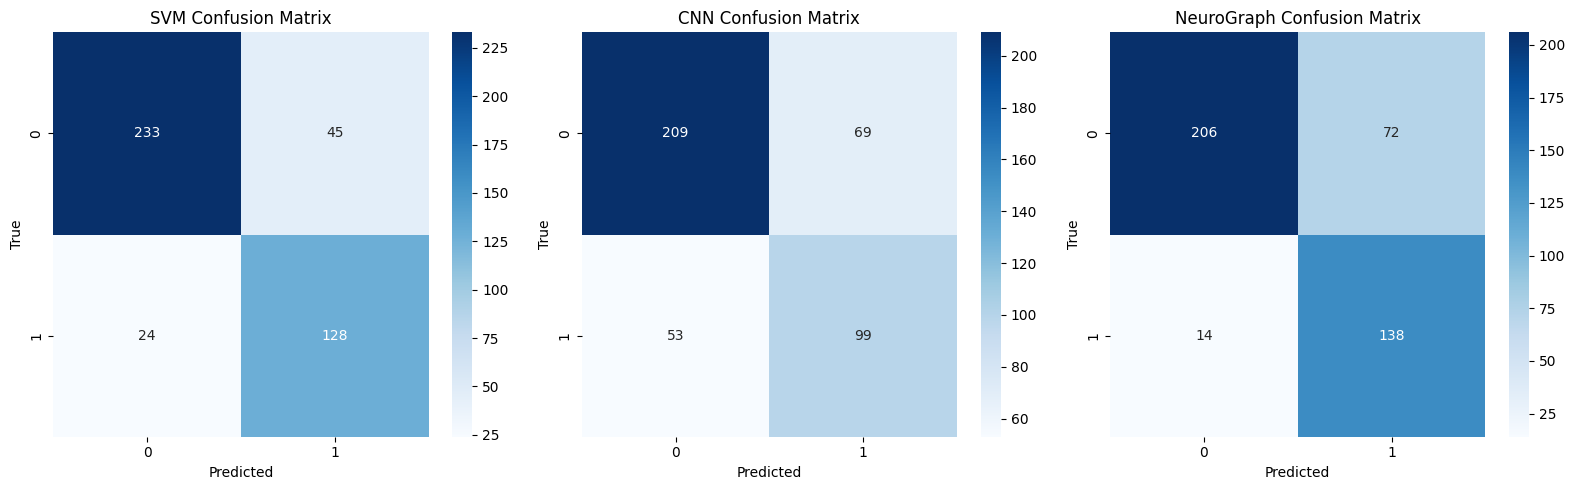

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "SVM": svm_pred,
    "CNN": cnn_pred,
    "NeuroGraph": ng_pred
}

plt.figure(figsize=(16,5))
for i, (name, pred) in enumerate(models.items(), 1):
    plt.subplot(1,3,i)
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()


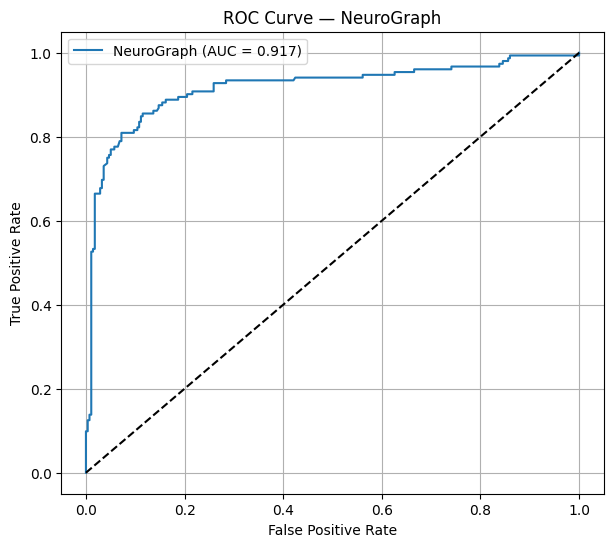

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize true labels (not strictly necessary for binary, but kept for consistency if it were multiclass)
# For binary classification, y_test_bin will have shape (n_samples, 1)
y_test_bin = label_binarize(y_test, classes=list(np.unique(y_test)))

# NeuroGraph predicted probabilities
# The variable 'probs_full' already holds the NeuroGraph predictions from the previous cell.
ng_prob = probs_full

plt.figure(figsize=(7,6))

# Since it's binary classification, y_test_bin.shape[1] will be 1
# We can directly plot the ROC for the positive class (class 1)
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], ng_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"NeuroGraph (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — NeuroGraph")
plt.legend()
plt.grid()
plt.show()

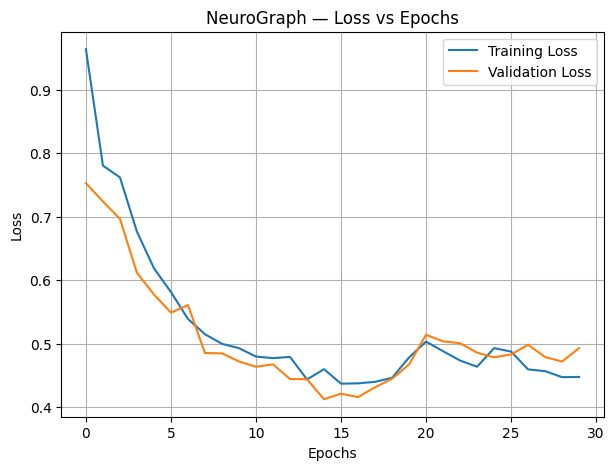

In [11]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("NeuroGraph — Loss vs Epochs")
plt.legend()
plt.grid()
plt.show()

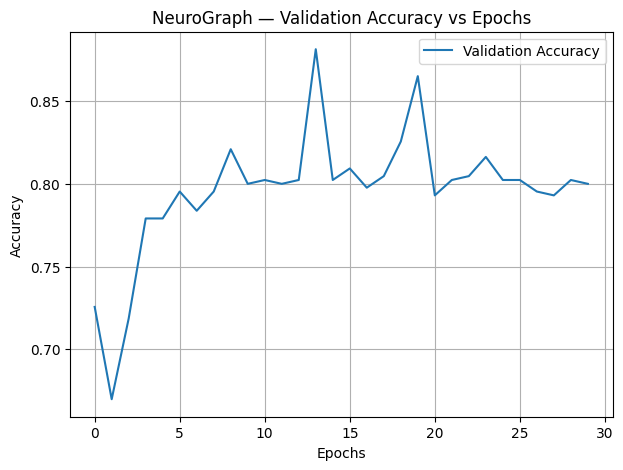

In [13]:
plt.figure(figsize=(7,5))
# plt.plot(ng_hist.history['accuracy'], label='Training Accuracy') # Training accuracy was not explicitly stored
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("NeuroGraph — Validation Accuracy vs Epochs")
plt.legend()
plt.grid()
plt.show()